# Gender Classification Using CNN Model
## DOE Design Point: Run 06
This notebook demonstrates a pipeline for binary gender classification from facial images using Convolutional Neural Networks (CNNs). A Design of Experiments (DOE) approach is used to systematically explore various architectural and training hyperparameters to optimize model performance. For further information regarding DOE study as well as the analysis of results, please visit "Project Information & Introduction.pdf" as well as "Results of DOE and Post-DOE Studies.pdf" documents in the project repository.

In [ ]:
import pandas
import numpy
import matplotlib
import seaborn
import tensorflow

print(f"pandas version is: {pandas.__version__}")
print(f"numpy version is: {numpy.__version__}")
print(f"matplotlib version is: {matplotlib.__version__}")
print(f"seaborn version is: {seaborn.__version__}")
print(f"tensorflow version is: {tensorflow.__version__}")

pandas version is: 2.2.2
numpy version is: 1.26.4
matplotlib version is: 3.9.2
seaborn version is: 0.13.2
tensorflow version is: 2.19.0


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#%matplotlib inline
import seaborn as sns
import tensorflow as tf

import src.data_loader
from src.model_builder import create_and_compile_model, reset_model_weights, get_callbacks
from src.training_utils import train_model, evaluate_model, plot_confusion_matrix, plot_metrics
import src.image_predictor

### 1. Design Point (here for DOE Run=6):

In [ ]:
# DOE factors:
run_value = 6
learning_rate_value = 0.0005
dropout_value = 0.2
# n-conv_layers = 4
n_units_last_layer_value = 4096
n_filters_l1_value = 32
n_filters_l2_value = 16

### 2. Load Dataset

We begin by loading the dataset using a custom data loader. The dataset consists of facial portraits labeled by gender. The images have been preprocessed to a uniform size and split into training, validation, and test set It is designed based on the collected small image dataset which is descussed in details in 'README.txt' and 'Project Information & Introduction.pdf' files. You can modify your own personal DATA_DIR in the 'data_loader.py' file to load your own dataset for the classification.

**Note: As the employed image dataset only has 943 images in total, we do not asign any images for the testing in the following code. We only selected 10% of the images in both classes as validation dataset. If you have a big image dataset, you can select any portion of it as a testing dataset.**.


In [4]:
img_size = 130
batch_size = 32
validation_split = 0.1
test_split = 0.00
shuffle_buffer_size = 1000
seed_num = 101

female_count, male_count = data_loader.get_image_counts()
print(f"There are {female_count} images of females.")
print(f"There are {male_count} images of males.")

train_dataset, val_dataset, test_dataset = data_loader.load_datasets(
    img_size, batch_size, validation_split, test_split, seed_num, shuffle_buffer_size
)

train_dataset, val_dataset, test_dataset = data_loader.optimize_datasets(
    train_dataset, val_dataset, test_dataset, shuffle_buffer_size
)

example_batch_images, example_batch_labels = data_loader.get_example_batch(train_dataset)
print(f"Maximum pixel value of images: {np.max(example_batch_images)}")
print(f"Shape of batch of images: {example_batch_images.shape}")
print(f"Shape of batch of labels: {example_batch_labels.shape}")

There are 471 images of females.
There are 472 images of males.
Found 943 files belonging to 2 classes.
Using 849 files for training.
Found 943 files belonging to 2 classes.
Using 94 files for validation.
Maximum pixel value of images: 255.0
Shape of batch of images: (32, 130, 130, 3)
Shape of batch of labels: (32, 1)


### 3.  Build and Train the CNN Model

We now define a custom CNN architecture with configurable parameters such as learning rate, dropout rate, number of dense units, and number of filters in convolutional layers. These parameteshould be selected based on theour Ddesign pointss For further information, please visit "Project Information & Introduction.pdf".is.

In [5]:
model = create_and_compile_model(img_size=130, 
                     learning_rate=learning_rate_value, 
                     dropout=dropout_value, 
                     n_units_last_layer=n_units_last_layer_value,
                     n_filters_l1= n_filters_l1_value,
                     n_filters_l2= n_filters_l2_value,
                     loss='binary_crossentropy',
                     metrics=['accuracy'])
model.summary()
#history = train_and_evaluate(model, train_ds, val_ds, callbacks=get_callbacks(0.87, 0.87))

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (None, 130, 130, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling (Rescaling)                │ (None, 130, 130, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 127, 127, 32)        │           1,568 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 61, 16)          │           4,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 64)          │           9,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 12, 12, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2304)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 2304)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 4096)                │       9,441,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │           4,097 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,497,777 (36.23 MB)

 Trainable params: 9,497,777 (36.23 MB)

 Non-trainable params: 0 (0.00 B)

### 4. Fitting the Model into Traning Dataset

Wfit the model to the training dataset and using validation dataset for checking the performance afterwards. It is important that in this stage of the project (in DOE sutdy), we fix the epochs=15 to have comparible base for all the DOE design points. Later, in the next stage of the project (in Post-DOE study), we optimize the selected DOE runs by employing Learning Rate Decay as well as Training and Validation Accuracy Callbacks.a.

**IMPORTANT NOTE: Learning Rate Decay is defined as follows. But it is not activated as it returns (lr * 1.0) which is lr itself.**

In [6]:
from tensorflow.keras.callbacks import LearningRateScheduler

# Reduce LR every 10 epochs (Learning rate decay factor)
def scheduler(epoch, lr):
    if epoch % 10 == 0 and epoch > 0:
        return lr * 1.0
    return lr

lr_callback = LearningRateScheduler(scheduler)

In [7]:
epochs = 15
verbose = 2

training_history = train_model(model=model, 
                               train_ds=train_dataset, 
                               val_ds=val_dataset, 
                               callbacks=[lr_callback], 
                               epochs=epochs, 
                               verbose =verbose)

Epoch 1/15
27/27 - 5s - 169ms/step - accuracy: 0.6078 - loss: 0.6584 - val_accuracy: 0.6489 - val_loss: 0.6595 - learning_rate: 5.0000e-04
Epoch 2/15
27/27 - 2s - 81ms/step - accuracy: 0.6926 - loss: 0.5881 - val_accuracy: 0.6915 - val_loss: 0.6259 - learning_rate: 5.0000e-04
Epoch 3/15
27/27 - 2s - 75ms/step - accuracy: 0.7326 - loss: 0.5327 - val_accuracy: 0.7128 - val_loss: 0.5219 - learning_rate: 5.0000e-04
Epoch 4/15
27/27 - 2s - 76ms/step - accuracy: 0.7585 - loss: 0.5124 - val_accuracy: 0.7234 - val_loss: 0.5341 - learning_rate: 5.0000e-04
Epoch 5/15
27/27 - 2s - 75ms/step - accuracy: 0.7621 - loss: 0.4858 - val_accuracy: 0.8298 - val_loss: 0.4563 - learning_rate: 5.0000e-04
Epoch 6/15
27/27 - 2s - 76ms/step - accuracy: 0.7774 - loss: 0.4635 - val_accuracy: 0.8298 - val_loss: 0.4504 - learning_rate: 5.0000e-04
Epoch 7/15
27/27 - 2s - 77ms/step - accuracy: 0.8115 - loss: 0.4322 - val_accuracy: 0.8511 - val_loss: 0.4246 - learning_rate: 5.0000e-04
Epoch 8/15
27/27 - 2s - 75ms/step

### 5. Evaluate Model Performance

We assess the model's performance using standard classification metrics, including precision, recall, and F1-score. This helps quantify the model's ability to generalize on unseen validation data.

In [8]:
result_history = pd.DataFrame(model.history.history)
result_history.head(15)

,accuracy,loss,val_accuracy,val_loss,learning_rate
0,0.607774,0.658358,0.648936,0.659549,0.0005
1,0.692580,0.588071,0.691489,0.625931,0.0005
2,0.732627,0.532688,0.712766,0.521905,0.0005
3,0.758539,0.512435,0.723404,0.534087,0.0005
4,0.762073,0.485787,0.829787,0.456296,0.0005
5,0.777385,0.463492,0.829787,0.450415,0.0005
6,0.811543,0.432156,0.851064,0.424636,0.0005
7,0.811543,0.419524,0.829787,0.410532,0.0005
8,0.831567,0.386567,0.840426,0.450821,0.0005
9,0.842167,0.356353,0.851064,0.395832,0.0005


<Figure size 600x400 with 0 Axes>

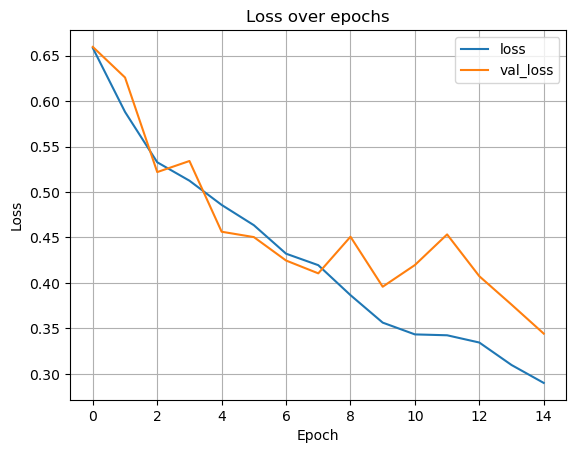

<Figure size 600x400 with 0 Axes>

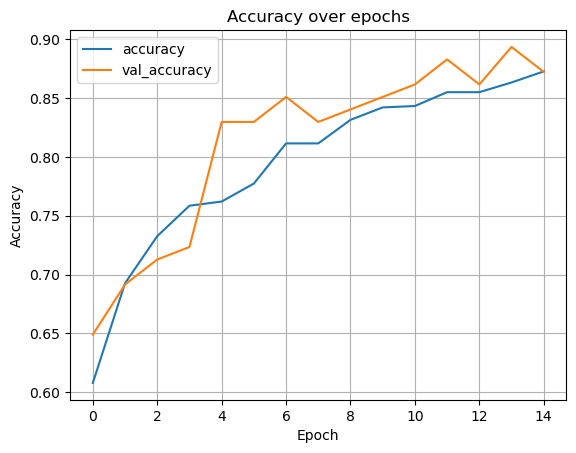

In [9]:
plot_metrics(result_history, run=run_value)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
Classification Report:
               precision    recall  f1-score   support

      Female       0.84      0.88      0.86        41
        Male       0.90      0.87      0.88        53

    accuracy                           0.87        94
   macro avg       0.87      0.87      0.87        94
weighted avg       0.87      0.87      0.87        94

Confusion Matrix:



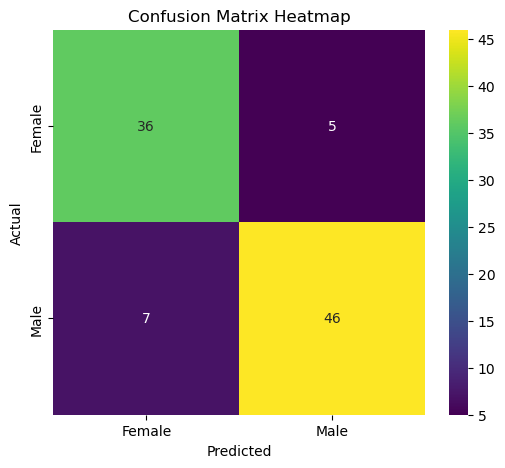

In [10]:
report, conf_matrix = evaluate_model(model, val_dataset)
print("Classification Report:\n", report)
print("Confusion Matrix:\n")
plot_confusion_matrix(conf_matrix)

### 6. Save the Model
We save the model if we are satisfied with the model performance presented above.

In [ ]:
model.save(f'gender_recognition_DOE_run{run_value}.h5')

### 7. Model Prediction using a Personal Image
We address an image path as input and returns both the prediction and CNN layer visualization.

**NOTE: You can also address your own your_image_path to predict your gender based on your loaded portrait image**

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
Prediction result: Male (confidence= 95.72 %)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 459ms/step


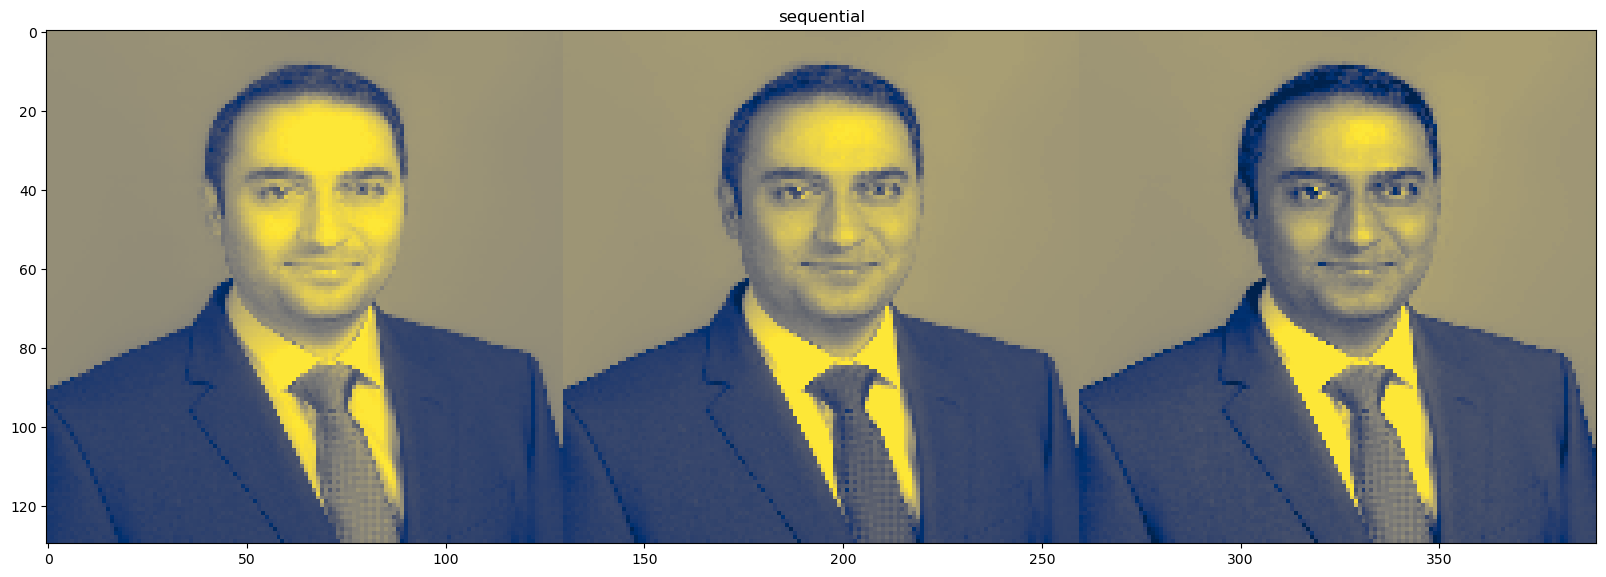

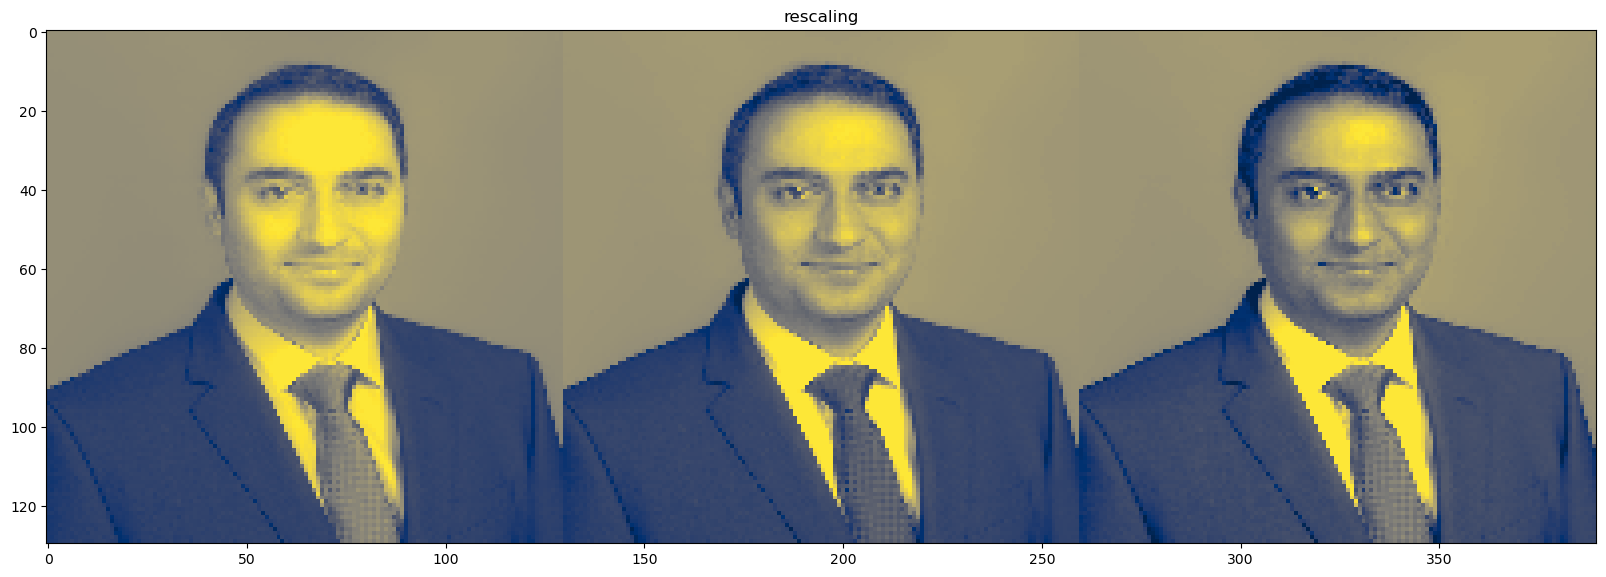

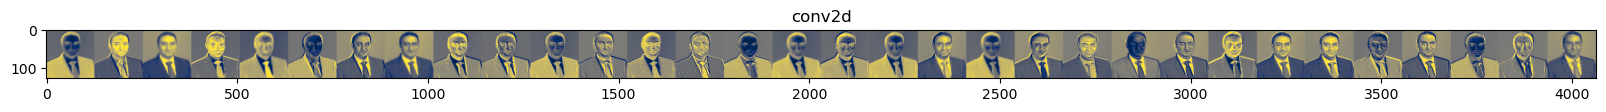

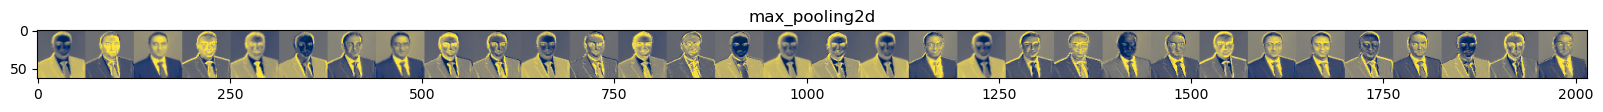

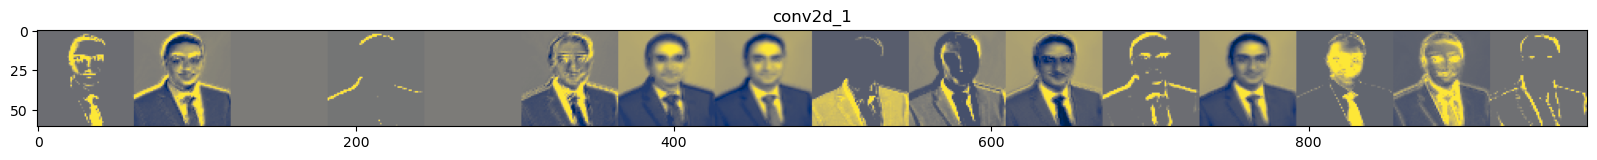

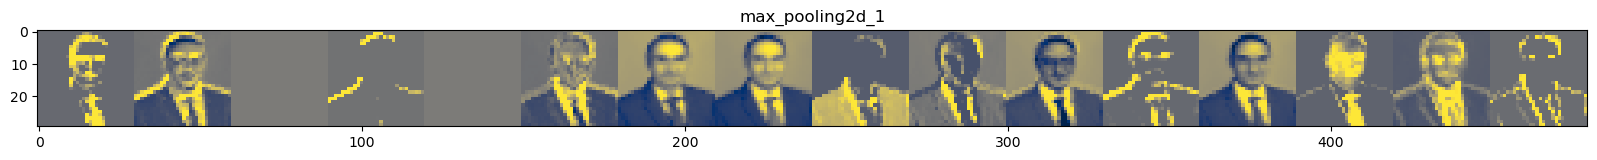

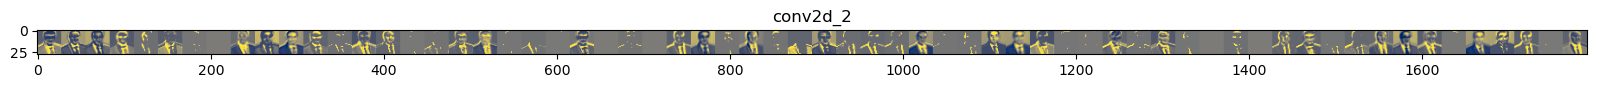

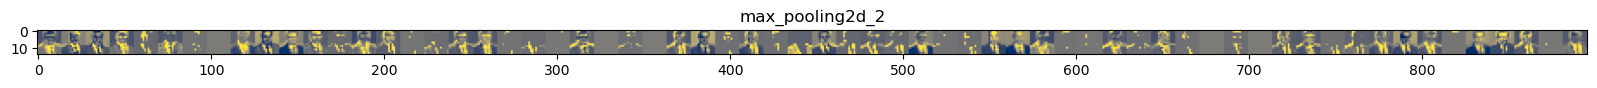

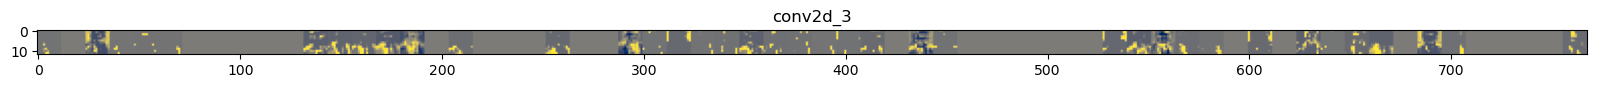

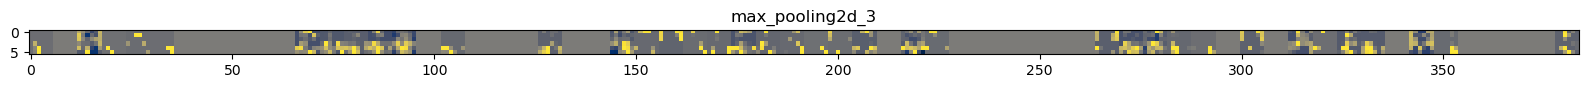

In [14]:
model_path = f'gender_recognition_DOE_run{run_value}.h5'
your_image_path = "D:\\Hossein's desktop files in Microsoft Studio Laptop\\Personal Photos\\Hossein_10.jpg"

model = image_predictor.load_model(model_path)
result, confidence, final_img = image_predictor.predict_image(model, your_image_path, img_size)
print(f"Prediction result: {result} (confidence= {confidence:.2f} %)")
image_predictor.visualize_layers(model, final_img, img_size)